In [1]:
# 利用 LSTM 做一个 Seq2Seq 的预测，不考虑准确性
## Architecture 
## General:        [x1, x2, ... , xn]   ==> [Seq2Seq Model] ==> [Prediction1, Prediction2] 
## Genral Data:    [122-D, ... , 122-D] ==> [Seq2Seq Model] ==> [1-D, 1-D] 
## Detail :        [x1, x2, ... , xn]   ==> [Encoder] ==> [h_n, c_n] + [xn]    ==> [Decoder] ==> [Prediont1, Prediction2]
## Detail Data:    [122-D, ...., 122-D] ==> [Encoder] ==> [h_n, c_n] + [122-D] ==> [Decoder] ==> [1-D, 1-D]
## Decoder :       xn, [h_n, c_n] ==> FC(xn), [h_n, c_n] ==> [1-D, h_n, c_n] ==> LSTM(1-D, h_n, c_n) ==> pred1, h1, c1 ==> LSTM(pred1, h, c) ==> pred2, h2, c2 ==> LSTM...

In [2]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
import random
import matplotlib.pyplot as plt

# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date'], axis=1)
# print(dataset.columns)
# print(dataset.tail())
dataset.insert(1, 'future2',dataset.future)
dataset['future2'] = dataset['future'].shift(-1)
dataset = dataset.fillna(0)

# print(dataset.shape)
# print(dataset.tail())


# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
SEQ_LENGTH = 60
BATCH_SIZE = 8                                                    # 注意：BATCH_SIZE是要能够整除seq_count的
TEST_BATCH_COUNT = 1
Y_SEQ_LEN = 2                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
Y_DIM = 1
X_DIM = dataset.shape[1]-Y_SEQ_LEN                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))


total_batch_count = int(rolling_data.shape[0]/BATCH_SIZE)                                   # 把数据规划成 batch_count 个 batch


print("total batch count: {}".format(total_batch_count))
print("batch size: {}".format(BATCH_SIZE))

# rolling_data = rolling_data.reshape(total_batch_count, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)  # 把数据转成 total_batch_count x BATCH_SIZE x seq_len x in_dim 格式
# rolling_data = torch.tensor(rolling_data)
# print("rolling_data: {}".format(rolling_data.shape))
# train_batch_count = int((rolling_data.shape[0]-1)/BATCH_SIZE)
# test_batch_count = 1

train = rolling_data[:-1].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)  # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-BATCH_SIZE:].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)  # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

train = torch.tensor(train)
test  = torch.tensor(test)

# train = rolling_data[:train_batch_count, :, :, :]
# test  = rolling_data[train_batch_count:, :, :, :]

train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y_seq_len]  to  [test_batch_count, batch_size, y_seq_len, 1-dim]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train.shape[0]))
print("test_batch_count:  {}".format(test.shape[0]))

rolling_data shape: (441, 60, 130)
seq count: 441
seq length: 60
total batch count: 55
batch size: 8
train_x: torch.Size([55, 8, 60, 128])
train_y: torch.Size([55, 8, 2, 1])
test_x:  torch.Size([1, 8, 60, 128])
test_y:  torch.Size([1, 8, 2, 1])
train_batch_count: 55
test_batch_count:  1


In [3]:
# Define the Encoder & Decoder class

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size = self.hidden_dim, num_layers=self.num_layers, batch_first=True, dropout=dropout)
        # print("Encoder self.input_dim  : {}".format(self.input_dim))
        # print("Encoder self.hidden_dim  : {}".format(self.hidden_dim))
    
    def forward(self, x):
        # print("Encoder forward() x: {}".format(x.shape))
        outputs, (h_n, c_n) = self.lstm(x)
        # print("Encoder outputs :{}".format(outputs.shape))
        # print("Encoder h_n     :{}".format(h_n.shape))
        # print("Encoder c_n     :{}".format(c_n.shape))
        return outputs, h_n, c_n

    
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        
        self.lstm = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True, dropout=dropout)
        
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input, hidden, cell):
        # input : input batch data, size(input): [batch_size, feature_size]
        # notice input only has two dimensions since the input is batchs
        # of last coordinate of observed trajectory so the sequence length has been removed.
        
        # add sequence dimension to input, to allow use of nn.LSTM
        # print("Decoder forward() input size : {}".format(input.shape))
        # print("Decoder forward() hidden size: {}".format(hidden.shape))
        # print("Decoder forward() cell size  : {}".format(cell.shape))
        
        input = self.fc_in(input)

        lstm_output, (hidden, cell) = self.lstm(input, (hidden, cell))
        
        # print("Decoder forward() lstm_output: {}".format(lstm_output.shape))
        
        prediction = self.fc_out(lstm_output)         # prediction is [batch_size, output_dim]
        
        return prediction, hidden, cell
    
 

In [4]:
# Define the model class

DEC_INPUT_DIM   = 1
HIDDEN_DIM      = 768
NUM_LAYERS      = 5
ENC_DROPOUT     = 0.5
DEC_DROPOUT     = 0.5


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        self.decoder_fc_init= nn.Linear(encoder.input_dim, decoder.input_dim)
        # self.decoder_fc_input= nn.Linear(decoder.output_dim, decoder.input_dim)
        
        assert (encoder.hidden_dim == decoder.hidden_dim), "hidden dimension in encoder and decoder must be equal"       
        assert (encoder.num_layers == decoder.num_layers), "hidden layer numbers in encoder and decoder must be equal"
        
            
    def forward(self, x, y, teacher_forcing_ratio = 0.5):
        # x is the input to the encoder.
        # y is the output from the decoder
        # x = [batch size, encoder_in_sequence_len,  encoder_in_dim]               encoder_in_sequence_len=60, encoder_in_dim=122
        # y = [batch size, decoder_out_sequence_len, decoder_out_dim]              decoder_out_sequence_len=2, decoder_out_dim=1    
        # print("Seq2Seq forwar() x shape : {}".format(x.shape))
        # print("Seq2Seq forwar() y shape : {}".format(y.shape))

        decoder_out_seq_len = y.shape[1]                                                     # This is most important that define the output length
        
        # tensor to store decoder outputs of each time step; this outputs will calc loss with y, so its shape is same as y
        outputs = torch.zeros(y.shape).to(device)
        # print("Seq2Seq forward() outputs shape: {}".format(outputs.shape))
        
        _, hidden, cell = self.encoder(x)
        # print("encoder hidden shape: {}".format(hidden.shape))                            # [encoder_hidden_layer_number, batch_size, encoder_hidden_dim]
        # print("encoder cell shape :  {}".format(cell.shape))                              # [encoder_hidden_layer_number, batch_size, encoder_hidden_dim]
        
        # first input to decoder may be last coordinates of x to predict the future: [last_x]+[h_n,c_n] --> [model] --> [future_y]
        decoder_input = x[:, -1, :]                                                           # [batch_size, encoder_input_dim] Get last elements of sequences of the batch from input x
        decoder_input = decoder_input.unsqueeze(1)                                            # [batch_size, 1, encoder_input_dim] Get last element of sequence of the batch in encoder
        # print("decoder_input: {}".format(decoder_input.shape))
        decoder_input = self.decoder_fc_init(decoder_input)                                   # [batch_size, 1, decoder_input_dim] Conver to 1st element of sequence of the batch in decoder
        # print("decoder_input: {}".format(decoder_input.shape))
        
        # Becasue the input and target have different sequence length, Get the target prediction one by one [Prev_prediction]+[h_n,c_n] --> [model] --> [Prediction]
        for i in range(decoder_out_seq_len):
            # run the decoder for one time step
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            # print("Seq2Seq forward() output shape: {}".format(output.shape))

            # place predictions in a tensor holding predictions for each time step
            outputs[:,i,:] = output[:,0]
            # print("Seq2Seq forward() outputs shape: {}".format(outputs.shape))            

            # assign this prediction as next prediction's input
            decoder_input = output
            # print("Seq2Seq forward() decoder_input shape: {}".format(output.shape))
            
            # 或者使用teacher_forcing来优化
            teacher_forcing = random.random() < teacher_forcing_ratio
            decoder_input = y[:, i, :].unsqueeze(1) if teacher_forcing else output
        return outputs
        

In [5]:
# 实例化模型
encoder = Encoder(input_dim=X_DIM, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=ENC_DROPOUT)
decoder = Decoder(input_dim=DEC_INPUT_DIM, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, output_dim=Y_DIM, dropout=DEC_DROPOUT)

model = Seq2Seq(encoder, decoder).double().to(device)


In [7]:
# 训练 Seq2Seq 模型; 
LR = 1e-4
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, last_epoch=-1)


model.train()
epoches = 2
epoch_loss = 0
epoch_loss_list = []

for epoch in range(epoches):
    for step in range(train_x.shape[0]):
        pred = model(train_x[step], train_y[step], teacher_forcing_ratio=0.5)
        # print("Train pred shape : {}".format(pred.shape))
        # print("Train train_y[step] shape : {}".format(train_y[step].shape))
        
        loss = loss_func(pred, train_y[step].float())              # this calc the last element's loss between prediction and real.
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        epoch_loss += loss.data.cpu()

    print("{} of {} epoch loss: {:.6f}".format(epoch, epoches, epoch_loss))
    epoch_loss_list.append(epoch_loss)
    epoch_loss = 0
    
    if (epoch+1)%40 == 0:
        scheduler.step()

0 of 2 epoch loss: 0.461892
1 of 2 epoch loss: 0.462579


Prediction Loss average:0.000000
Prediction: tensor([[-0.0179],
        [-0.0199]], device='cuda:0', grad_fn=<SelectBackward0>) ---- Actual: tensor([[0.],
        [0.]], device='cuda:0', dtype=torch.float64)


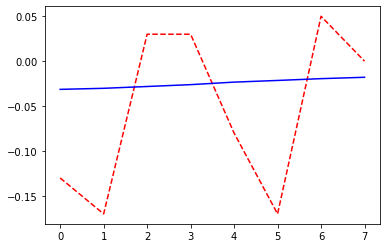

In [14]:
# 用模型预测数据
model.eval()
test_loss = 0

for step in range(test_x.shape[0]):
    pred = model(test_x[step], test_y[step], teacher_forcing_ratio=0)                       # 测试集上就不要teacher模式了。

    loss = loss_func(pred, test_y[step])
    
    if (step+1) < test_x.shape[0]:                                                         # 最后一个测试数据不需要统计，因为没有真实值。
        test_loss += loss.cpu()
    
    if test_x.shape[0] == 1:
        print("Prediction Loss average:{:.6f}".format(test_loss/test_x.shape[0]))
    else:
        print("Prediction Loss average:{:.6f}".format(test_loss/(test_x.shape[0]-1)))
        
    print("Prediction: {} ---- Actual: {}".format(pred[-1], test_y[step][-1]))

actual_line = test_y[step][:,0,:].cpu().detach().flatten().numpy()
pred_line   = pred[:,0,:].cpu().detach().flatten().numpy()
plt.plot(actual_line, 'r--')
plt.plot(pred_line, 'b-')
plt.show()